# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 37.5 MB/s eta 0:00:0031m46.3 MB/s eta 0:00:01
Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)


Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [2]:
import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoneremin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
if torch.backends.mps.is_available():
    device = 'mps'  # MPS (Metal Performance Shaders) для Apple Silicon
elif torch.cuda.is_available():
    device = 'cuda'  # Для CUDA
else:
    device = 'cpu'  # CPU fallback

device

'mps'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [148]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [10]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [11]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!


# Базовая модель

Обучим модель, которая была в семинаре, после чего сделаем замеры. это будет нашей отправной точкой. После чего, все остальные модели мы будем сравнивать именно с ней.

## Замечание по текущей модели и последующим

Так как аггреция по среднему показывает немного более высокое качество чем по max, а также более стабильна в плане роста качества в зависимости от номера итерации, поэтому в наших моделях мы зафиксируем только один вид аггрегации -> mean.

## Описание планируемых экспериментов

Оставляем тип аггрегации mean. В целом для 5ти эпох и текущей задачи, данный параметр не влияет на качество, поэтому для простоты эксперимента и ускорении вычислений, зафиксируем его именно как mean.

Эксперименты:
1. Модель без изменений.
2. Базовая модель, но вместо слоя RNN используем GRU.
3. Базовая модель с LSTM.
4. Пробуем скомбинировать два слоя: RNN + GRU.

Затем проводим серию экспериментов с моделью у которой максимальное значение accuracy и меняем у неё следующие параметры:
1. Изменяем количество слоёв num_layers для модели RNN: ставим значение 3 и 5.
2. Пробуем агрегацию следующего вида: mean + последний токен (конкатенация), max + последний токен.
3. Меняем размер словаря, изменяя параметр threshold: сначала с 25 до 10 (один эксперимент), затем до 5 (второй эксперимент). Ожидаем, что размер словаря существенно увеличится.
4. Изменяем размер скрытого слоя hidden_dim с 256 до 512.
5. Меняем параметр Dropout с 0.1 до 0.2 и до 0.3.

In [23]:
class RNN_Model(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        num_classes: int = 4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.mean(dim=1) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

# Cоздаем Объект класса модели
rnn_basic_model = RNN_Model(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(rnn_basic_model.parameters())

In [24]:
# Общий метод тренировки модели который мы будем использовать для всех моделей
def train_model(model, train_dataloader, eval_dataloader):
  num_epoch = 10
  eval_steps = len(train_dataloader) // 2

  losses = []
  acc = []

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()

        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

  return [losses, acc, model]

In [25]:
rnn_basic_model_losses, rnn_basic_model_acc, rnn_basic_model = train_model(rnn_basic_model, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [26]:
class GRU_basic(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        num_classes: int = 4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.mean(dim=1) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

# Cоздаем Объект класса модели
gru_basic_model = GRU_basic(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru_basic_model.parameters())

In [27]:
gru_basic_model_losses, gru_basic_model_acc, gru_basic_model_mdl = train_model(gru_basic_model, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [28]:
class LSTM_basic(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        num_classes: int = 4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.mean(dim=1)  # [batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

# Cоздаем Объект класса модели
lstm_basic_model = LSTM_basic(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(lstm_basic_model.parameters())

In [29]:
lstm_basic_model_losses, lstm_basic_model_acc, lstm_basic_model_mdl = train_model(lstm_basic_model, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [30]:
class RNN_GRU_basic(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        num_classes: int = 4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.mean(dim=1)  # [batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

# Cоздаем Объект класса модели
rnn_gru_basic_model = RNN_GRU_basic(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(rnn_gru_basic_model.parameters())

In [31]:
rnn_gru_basic_model_losses, rnn_gru_basic_model_acc, rnn_gru_basic_model_mdl = train_model(rnn_gru_basic_model, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

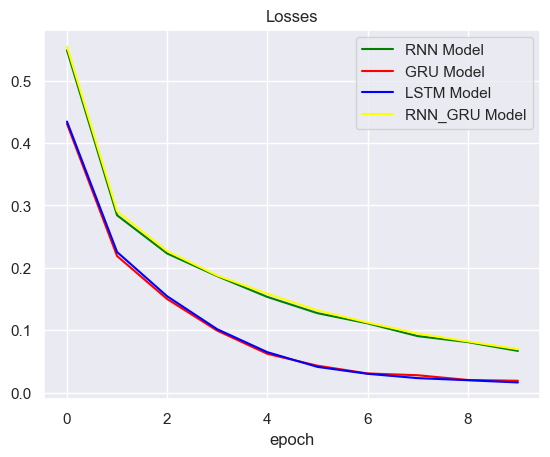

In [32]:
# Нарисуем графики Losses для трех моделей.
plt.plot(np.arange(len(rnn_basic_model_losses)), rnn_basic_model_losses, color='green', label='RNN Model')
plt.plot(np.arange(len(gru_basic_model_losses)), gru_basic_model_losses, color='red', label='GRU Model')
plt.plot(np.arange(len(lstm_basic_model_losses)), lstm_basic_model_losses, color='blue', label='LSTM Model')
plt.plot(np.arange(len(rnn_gru_basic_model_losses)), rnn_gru_basic_model_losses, color='yellow', label='RNN_GRU Model')


plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

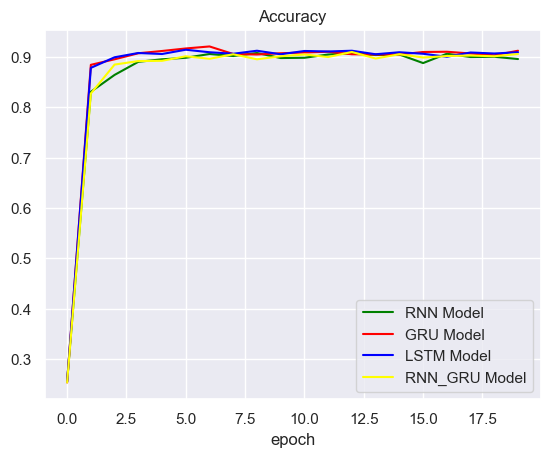

In [33]:
# Нарисуем графики значения Accuracy для трех моделей.
plt.plot(np.arange(len(rnn_basic_model_acc)), rnn_basic_model_acc, color='green', label='RNN Model')
plt.plot(np.arange(len(gru_basic_model_acc)), gru_basic_model_acc, color='red', label='GRU Model')
plt.plot(np.arange(len(lstm_basic_model_acc)), lstm_basic_model_acc, color='blue', label='LSTM Model')
plt.plot(np.arange(len(rnn_gru_basic_model_acc)), rnn_gru_basic_model_acc, color='yellow', label='RNN_GRU Model')

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [34]:
# Подсчитаем итоговое значение точно и выберем модель, с максимальным значеним для будущих экспериментов
rnn_model_accuracy = evaluate(rnn_basic_model, eval_dataloader)
gru_model_accuracy = evaluate(gru_basic_model, eval_dataloader)
lstm_model_accuracy = evaluate(lstm_basic_model, eval_dataloader)
rnn_gre_model_accuracy = evaluate(rnn_gru_basic_model_mdl, eval_dataloader)

print(f'RNN model accuracy: {rnn_model_accuracy}')
print(f'GRU model accuracy: {gru_model_accuracy}')
print(f'LSTM model accuracy: {lstm_model_accuracy}')
print(f'RNN_GRU model accuracy: {rnn_gre_model_accuracy}')

RNN model accuracy: 0.8990000486373901
GRU model accuracy: 0.9050000309944153
LSTM model accuracy: 0.9110000729560852
RNN_GRU model accuracy: 0.8990000486373901


In [178]:
del rnn_basic_model
del gru_basic_model
del rnn_gru_basic_model_mdl

# Выводы по первому шагу

Были обучены 4 модели:
1. RNN
2. GRU
3. LSTM
4. RNN + GRU

Итоговое качество моделей было примерно одинаковое, однако наивысшее качество после 10 эпох обучения было у LSTM модели именно её мы и будем дальше использовать. Идея соединить в одну модель слои RNN + GRU не оправдала себя. Обучим LSTM на большем числе эпох - 20 и 

In [15]:
# Перепишем класс LSTM добавим в него некоторые параметры, для проведения разных кспериментов
class LSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout_value: float, num_layers: int, num_classes: int = 4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = output.mean(dim=1)  # [batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [167]:
# Обучаем LSTM с 3мя слоями
lstm_3_layers = LSTM(hidden_dim=256, vocab_size=len(vocab), num_layers=3, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_3_layers.parameters())

In [41]:
lstm_3_layers_losses, lstm_3_layers_acc, lstm_3_layers_mdl = train_model(lstm_3_layers, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [42]:
# Обучаем LSTM с 3мя слоями
lstm_5_layers = LSTM(hidden_dim=256, vocab_size=len(vocab), num_layers=5, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_5_layers.parameters())

In [43]:
lstm_5_layers_losses, lstm_5_layers_acc, lstm_5_layers_mdl = train_model(lstm_5_layers, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

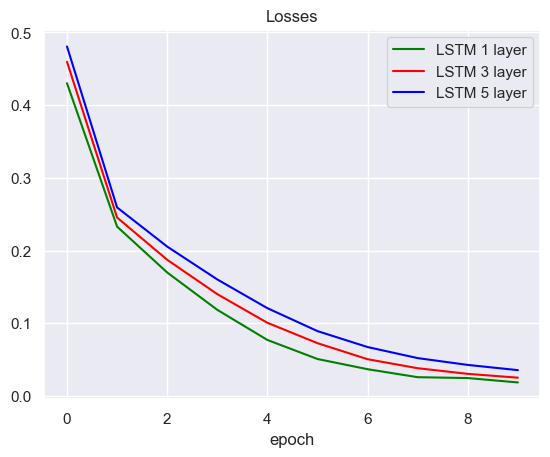

In [44]:
# Нарисуем графики Losses для LSTM сетки с разным числом слоев
plt.plot(np.arange(len(lstm_basic_model_losses)), lstm_basic_model_losses, color='green', label='LSTM 1 layer')
plt.plot(np.arange(len(lstm_3_layers_losses)), lstm_3_layers_losses, color='red', label='LSTM 3 layer')
plt.plot(np.arange(len(lstm_5_layers_losses)), lstm_5_layers_losses, color='blue', label='LSTM 5 layer')


plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

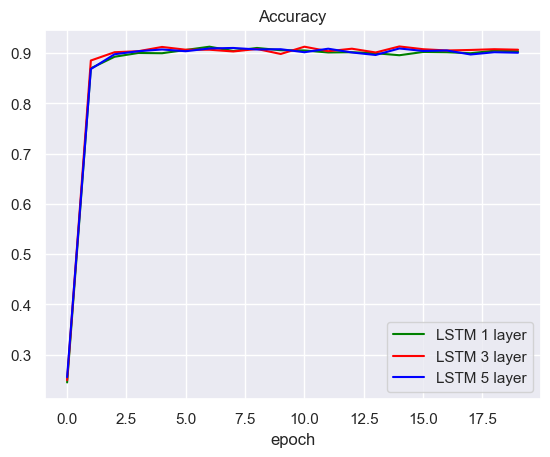

In [45]:
# Нарисуем графики значения Accuracy для трех моделей.
plt.plot(np.arange(len(lstm_basic_model_acc)), lstm_basic_model_acc, color='green', label='LSTM 1 layer')
plt.plot(np.arange(len(lstm_3_layers_acc)), lstm_3_layers_acc, color='red', label='LSTM 3 layer')
plt.plot(np.arange(len(lstm_5_layers_acc)), lstm_5_layers_acc, color='blue', label='LSTM 5 layer')

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [46]:
# Выберем LSTM сеть с лучшим числом слоев
lstm_model_1_layer_accuracy = evaluate(lstm_basic_model, eval_dataloader)
lstm_model_3_layers_accuracy = evaluate(lstm_3_layers_mdl, eval_dataloader)
lstm_model_5_layers_accuracy = evaluate(lstm_5_layers_mdl, eval_dataloader)

print(f'LSTM model accuracy with 1 layer: {lstm_model_1_layer_accuracy}')
print(f'LSTM model accuracy with 3 layers: {lstm_model_3_layers_accuracy}')
print(f'LSTM model accuracy with 5 layers: {lstm_model_5_layers_accuracy}')

LSTM model accuracy with 1 layer: 0.9010000228881836
LSTM model accuracy with 3 layers: 0.8980000615119934
LSTM model accuracy with 5 layers: 0.9005000591278076


In [179]:
del lstm_3_layers_mdl
del lstm_5_layers_mdl

# Вывод по кол-ву слоев.
Как мы видим, но увеличение числа слоев не дало прироста в качестве модели.

In [47]:
# Обучаем LSTM со скрытым слоем в 128
lstm_hidden_dim_128 = LSTM(hidden_dim=128, vocab_size=len(vocab), num_layers=1, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_hidden_dim_128.parameters())

lstm_hidden_dim_128_losses, lstm_hidden_dim_128_acc, lstm_hidden_dim_128_mdl = train_model(lstm_hidden_dim_128, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [38]:
# Обучаем LSTM со скрытым слоем в 512
lstm_hidden_dim_512 = LSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=1, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_hidden_dim_512.parameters())

lstm_hidden_dim_512_losses, lstm_hidden_dim_512_acc, lstm_hidden_dim_512_mdl = train_model(lstm_hidden_dim_512, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

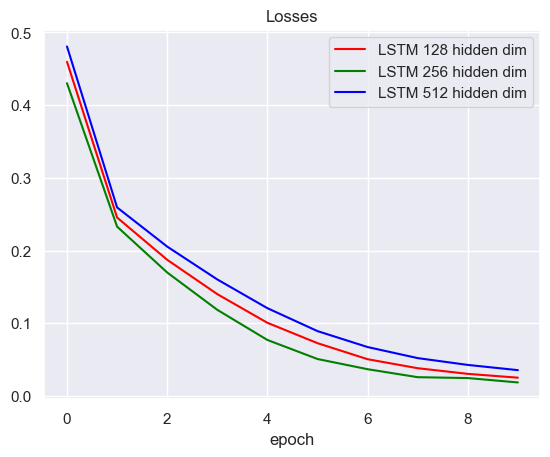

In [49]:
# Нарисуем графики Losses для LSTM сетки с разным размером векторов
plt.plot(np.arange(len(lstm_hidden_dim_128_losses)), lstm_3_layers_losses, color='red', label='LSTM 128 hidden dim')
plt.plot(np.arange(len(lstm_basic_model_losses)), lstm_basic_model_losses, color='green', label='LSTM 256 hidden dim')
plt.plot(np.arange(len(lstm_hidden_dim_512_losses)), lstm_5_layers_losses, color='blue', label='LSTM 512 hidden dim')


plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

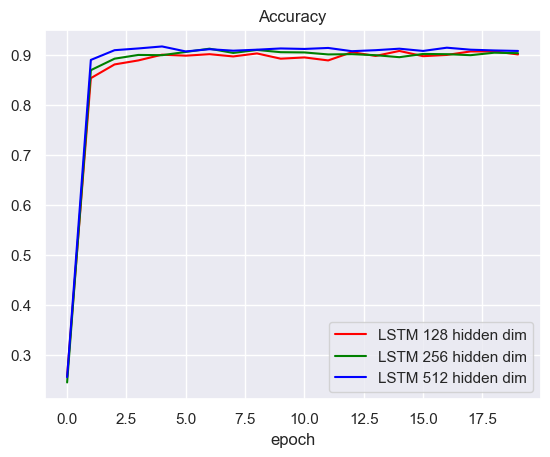

In [50]:
# Нарисуем графики значения Accuracy для трех моделей.
plt.plot(np.arange(len(lstm_hidden_dim_128_acc)), lstm_hidden_dim_128_acc, color='red', label='LSTM 128 hidden dim')
plt.plot(np.arange(len(lstm_basic_model_acc)), lstm_basic_model_acc, color='green', label='LSTM 256 hidden dim')
plt.plot(np.arange(len(lstm_hidden_dim_512_acc)), lstm_hidden_dim_512_acc, color='blue', label='LSTM 512 hidden dim')

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [67]:
# Выберем LSTM сеть с лучшим размером скрытого слоя
lstm_hidden_dim_128_mdl_accuracy = evaluate(lstm_hidden_dim_128_mdl, eval_dataloader)
lstm_hidden_dim_256_mdl_accuracy = evaluate(lstm_basic_model_mdl, eval_dataloader)
lstm_hidden_dim_512_accuracy = evaluate(lstm_hidden_dim_512_mdl, eval_dataloader)

print(f'LSTM model accuracy with 128 hidden dim: {lstm_hidden_dim_128_mdl_accuracy}')
print(f'LSTM model accuracy with 256 hidden dim: {lstm_hidden_dim_256_mdl_accuracy}')
print(f'LSTM model accuracy with 512 hidden dim: {lstm_hidden_dim_512_accuracy}')

LSTM model accuracy with 128 hidden dim: 0.9015000462532043
LSTM model accuracy with 256 hidden dim: 0.9015000462532043
LSTM model accuracy with 512 hidden dim: 0.9155000448226929


In [180]:
del lstm_hidden_dim_128_mdl
del lstm_basic_model_mdl

# Краткий вывод по кол-ву размера внутреннего слоя
Как мы види существенный прирост мы получили при использовании размера скрытого слоя равного 512.

In [35]:
# Эксперимент по величине дропаута, будем проверять следующие варианты
# 1. LSTM, hidden_dim = 512, num_layers=1, dropout_value=0.1
# 2. LSTM, hidden_dim = 512, num_layers=1, dropout_value=0.3
# 3. LSTM, hidden_dim = 512, num_layers=1, dropout_value=0.5

In [36]:
# Обучаем LSTM со dropout 0.3
lstm_hidden_drop_03 = LSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=1, dropout_value=0.3).to(device)
optimizer = torch.optim.Adam(lstm_hidden_drop_03.parameters())

lstm_hidden_drop_03_losses, lstm_hidden_drop_03_acc, lstm_hidden_drop_03_mdl = train_model(lstm_hidden_drop_03, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [37]:
# Обучаем LSTM со dropout 0.5
lstm_hidden_drop_05 = LSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=1, dropout_value=0.5).to(device)
optimizer = torch.optim.Adam(lstm_hidden_drop_05.parameters())

lstm_hidden_drop_05_losses, lstm_hidden_drop_05_acc, lstm_hidden_drop_05_mdl = train_model(lstm_hidden_drop_05, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

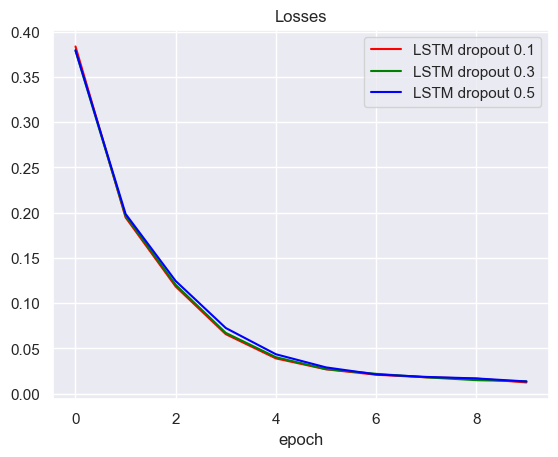

In [39]:
# Нарисуем графики Losses для LSTM сетки с разным значением дропаута
plt.plot(np.arange(len(lstm_hidden_dim_512_losses)), lstm_hidden_dim_512_losses, color='red', label='LSTM dropout 0.1')
plt.plot(np.arange(len(lstm_hidden_drop_03_losses)), lstm_hidden_drop_03_losses, color='green', label='LSTM dropout 0.3')
plt.plot(np.arange(len(lstm_hidden_drop_05_losses)), lstm_hidden_drop_05_losses, color='blue', label='LSTM dropout 0.5')


plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

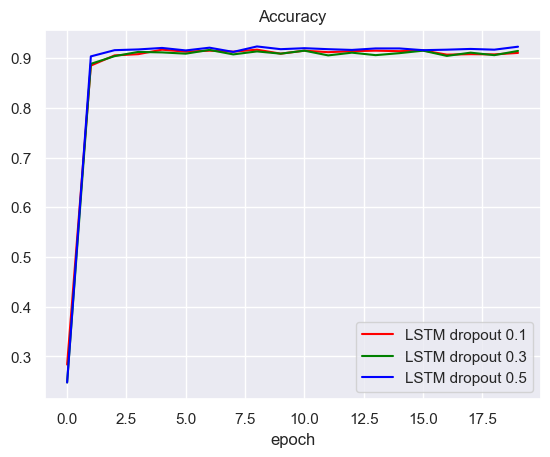

In [40]:
# Нарисуем графики значения Accuracy для LSTM сетки с разным значением дропаута
plt.plot(np.arange(len(lstm_hidden_dim_512_acc)), lstm_hidden_dim_512_acc, color='red', label='LSTM dropout 0.1')
plt.plot(np.arange(len(lstm_hidden_drop_03_acc)), lstm_hidden_drop_03_acc, color='green', label='LSTM dropout 0.3')
plt.plot(np.arange(len(lstm_hidden_drop_05_acc)), lstm_hidden_drop_05_acc, color='blue', label='LSTM dropout 0.5')

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [41]:
# Выберем LSTM сеть с лучшим размером скрытого слоя
lstm_hidden_dim_512_mdl_accuracy = evaluate(lstm_hidden_dim_512_mdl, eval_dataloader)
lstm_hidden_drop_03_mdl_accuracy = evaluate(lstm_hidden_drop_03_mdl, eval_dataloader)
lstm_hidden_drop_05_mdl_accuracy = evaluate(lstm_hidden_drop_05_mdl, eval_dataloader)

print(f'LSTM model accuracy with dopout 0.1: {lstm_hidden_dim_512_mdl_accuracy}')
print(f'LSTM model accuracy with dopout 0.3: {lstm_hidden_drop_03_mdl_accuracy}')
print(f'LSTM model accuracy with dopout 0.5: {lstm_hidden_drop_05_mdl_accuracy}')

LSTM model accuracy with dopout 0.1: 0.9070000648498535
LSTM model accuracy with dopout 0.3: 0.9155000448226929
LSTM model accuracy with dopout 0.5: 0.9160000681877136


In [174]:
# Удалим модели, с плохим качеством для экономии памяти:
del lstm_hidden_drop_03_mdl_accuracy
del lstm_hidden_drop_05_mdl_accuracy

In [139]:
# Перепишем класс LSTM добавим в него некоторые параметры, для проведения разных кспериментов
class LSTM_concat_layers(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout_value: float, num_layers: int, num_classes: int = 4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.projection = nn.Linear(2*hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        # Последний токен из последовательности h_n
        last_token = _[0][-1]

        # считаем среднее по всем выходам
        output = output.mean(dim=1)  # [batch_size, hidden_dim]

        # Производим вертикальную конкатенацию между среднем по всем выходам и последнему токену. Не забудем что размер выходного вектора тогда
        # будет hidden_dim * 2
        
        concateneted_output = torch.cat((output, last_token), dim=1)
        output = self.dropout(self.linear(self.non_lin(concateneted_output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [140]:
lstm_concat_layers_base_256 = LSTM_concat_layers(hidden_dim=256, vocab_size=len(vocab), num_layers=1, dropout_value=0.5).to(device)
optimizer = torch.optim.Adam(lstm_concat_layers.parameters())

lstm_concat_layers_base_256_losses, lstm_concat_layers_base_256_acc, lstm_concat_layers_base_256_mdl = train_model(lstm_concat_layers_base_256, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [157]:
evaluate(lstm_concat_layers_base_256_mdl, eval_dataloader)

0.2540000081062317

Конкатенация последнего слоя, а также усредненного не дала повышения ключевой метрики, более того метрика достаточно сильно ухудшилась.

Проведем последний эксперимент, а именно мы увеличим размер словаря посредством того, что изменим значение параметра threshold установим значение в 5.

In [8]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 5

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 27694


Заметим что размер словаря вырос более чем в 2 раза с 11842 до 27694

In [169]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [13]:
# Общий метод тренировки модели который мы будем использовать для всех моделей
def train_model(model, train_dataloader, eval_dataloader):
  num_epoch = 10
  eval_steps = len(train_dataloader) // 2

  losses = []
  acc = []

  for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()

        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

  return [losses, acc, model]

In [16]:
# Обучаем LSTM со скрытым слоем в 512
lstm_hidden_dim_512 = LSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=1, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_hidden_dim_512.parameters())

lstm_hidden_dim_512_losses, lstm_hidden_dim_512_acc, lstm_hidden_dim_512_mdl = train_model(lstm_hidden_dim_512, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [18]:
# Обучаем LSTM со скрытым слоем в 256
lstm_hidden_dim_256 = LSTM(hidden_dim=256, vocab_size=len(vocab), num_layers=1, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_hidden_dim_256.parameters())

lstm_hidden_dim_256_losses, lstm_hidden_dim_256_acc, lstm_hidden_dim_256_mdl = train_model(lstm_hidden_dim_256, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [19]:
# Обучаем LSTM со скрытым слоем в 128
lstm_hidden_dim_128 = LSTM(hidden_dim=128, vocab_size=len(vocab), num_layers=1, dropout_value=0.1).to(device)
optimizer = torch.optim.Adam(lstm_hidden_dim_128.parameters())

lstm_hidden_dim_128_losses, lstm_hidden_dim_128_acc, lstm_hidden_dim_128_mdl = train_model(lstm_hidden_dim_128, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

In [20]:
# Выберем LSTM сеть с максимальным качеством для расшиеренного словаря
lstm_hidden_dim_128_mdl_accuracy = evaluate(lstm_hidden_dim_128_mdl, eval_dataloader)
lstm_hidden_dim_256_mdl_accuracy = evaluate(lstm_hidden_dim_256_mdl, eval_dataloader)
lstm_hidden_dim_512_accuracy = evaluate(lstm_hidden_dim_512_mdl, eval_dataloader)

print(f'LSTM model accuracy with 128 hidden dim: {lstm_hidden_dim_128_mdl_accuracy}')
print(f'LSTM model accuracy with 256 hidden dim: {lstm_hidden_dim_256_mdl_accuracy}')
print(f'LSTM model accuracy with 512 hidden dim: {lstm_hidden_dim_512_accuracy}')

LSTM model accuracy with 128 hidden dim: 0.9075000286102295
LSTM model accuracy with 256 hidden dim: 0.9050000309944153
LSTM model accuracy with 512 hidden dim: 0.9140000343322754


Увеличение кол-ва размера словаря не улучшило итоговую метрику, поэтому качество модели не улучшилось.

# Итоговый вывод



На первом этапе были протестированы 4е архитектуры сетей:
1. RNN
2. GRU
3. LSTM
4. RNN+GRU

Качество на валидационной получилось следующее: 
RNN model accuracy: 0.899
GRU model accuracy: 0.905
LSTM model accuracy: 0.911
RNN_GRU model accuracy: 0.899

Таким образом мы видим, что наилучшее качество было у модели LSTM. Поэтому именно эта модель использовалась в следующих сериях экспериментах.
В первом эксперименте изменялся параметр количества внутренние слоев (параметр num_layers). Были использованы следующие значения: 1 (значение по умолчанию), 3 и 5. Самое высокое значение метрики было достигнуто при значении num_layers = 1. 

Следующий эксперимент был связан с изменением размера вектора hidden_dim также использовалось 128, 256 и 512. Лучшее значение было достигнуто при значении в 512.

Финальным экспериментом было изменение значения dropout. Проверялись 3 значения 0.1, 0.3, 0.5 Были получены следующие значения
LSTM model accuracy with dopout 0.1: 0.907
LSTM model accuracy with dopout 0.3: 0.915
LSTM model accuracy with dopout 0.5: 0.916

Итого на данном этапе лучшее качество было у модели LSTM со значением дропаута = 0.5, кол-во скрытх слоев num_layers=1 и размером вектора скрытого слоя = 512. Качество данной модели было равно: 0.916

Были проведены также 2 дополнительных эксперимента:
1. Было увеличен размер словаря при изменении параметра threshold с 25 до 5. При этом размер словаря вырос более чем в 2 раза с 11842 до 27694 однако это не увеличило значение целевой метрики. Возможно нужно использовать более глубокие сети или же увеличивать размер вектора эмбеддингов.
2. Для сети LSTM был изменен способ конкатенации векторов, те брался вектор с последнего токен + вектор усреднений по всем векторам, однако, данный способ изменения архитектуры так же не дал роста ключевой метрики.